In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れない場合はFalse
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, bias, verbose, lambda_):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.lambda_ = lambda_
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        y = y.reshape(-1, 1)
        if self.bias == True:
            X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
            if X_val is not None:
                X_val = np.concatenate([np.ones(X_val.shape[0]).reshape(-1, 1), X_val], axis=1)
            self.coef_ = np.random.rand(X.shape[1], 1)
            if self.verbose:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent(X, y)
                    j_theta = self._compute_cost(X, y)
                    self.loss[i] = j_theta
                    print('{}回目、theta:{}、j_theta:{}'.format(i+1, self.coef_, j_theta))
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost(X_val, y_val)
                        self.val_loss[i] = j_theta_val
                        print('{}回目、theta:{}、j_theta_val:{}'.format(i+1, self.coef_, j_theta_val))

            else:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent(X, y)
                    j_theta = self._compute_cost(X, y)
                    self.loss[i] = j_theta
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost(X_val, y_val)
                        self.val_loss[i] = j_theta_val
        
        elif self.bias == False:
            self.coef_ = np.random.rand(X.shape[1], 1)
            if self.verbose:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent_no_bias(X, y)
                    j_theta = self._compute_cost_no_bias(X, y)
                    self.loss[i] = j_theta
                    print('{}回目、theta:{}、j_theta:{}'.format(i+1, self.coef_, j_theta))
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost_no_bias(X_val, y_val)
                        self.val_loss[i] = j_theta_val
                        print('{}回目、theta:{}、j_theta_val:{}'.format(i+1, self.coef_, j_theta_val))

            else:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent_no_bias(X, y)
                    j_theta = self._compute_cost_no_bias(X, y)
                    self.loss[i] = j_theta
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost_no_bias(X_val, y_val)
                        self.val_loss[i] = j_theta_val

    def predict(self, X, threshold=0.5):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias is True:
            X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
        y_predict_proba = self._logistic_hypothsis(X)
        y_pred = np.where(y_predict_proba >= threshold, 1, 0)
        
        return y_pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias is True:
            X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
        y_predict_proba = self._logistic_hypothsis(X)
        
        return y_predict_proba
    
    def _logistic_hypothsis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰の仮定関数の値
        """
        h_theta = 1/(1 + np.exp(-np.dot(X, self.coef_)))
        
        return h_theta
    
    def _gradient_descent(self, X, y):
        """
        最急降下法により特徴量の重みのパラメータを更新する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        
        y : 次の形のndarray, shape (n_samples, )
            正解値

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            重み
        """
        self.coef_[0] -= self.lr*(np.dot(X[:, 0].T, (self._logistic_hypothsis(X) - y))/X.shape[0])
        self.coef_[1:] -= self.lr*(np.dot(X[:,1:].T, (self._logistic_hypothsis(X) - y))/X.shape[0]\
                                 + self.lambda_*self.coef_[1:]/X.shape[0])
                                 
        return self.coef_
    
    def _gradient_descent_no_bias(self, X, y):
        """
        最急降下法により特徴量の重みのパラメータを更新する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        
        y : 次の形のndarray, shape (n_samples, )
            正解値

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            重み
        """
        self.coef_ -= self.lr*(np.dot(X.T, (self._logistic_hypothsis(X) - y))/X.shape[0] + self.lambda_*self.coef_/X.shape[0])
                                 
        return self.coef_
        
    def _compute_cost(self, X, y):
        j_theta = (-np.dot(y.T, np.log(self._logistic_hypothsis(X))) - np.dot((1 - y).T, np.log(1 - self._logistic_hypothsis(X))))\
                   /X.shape[0] + self.lambda_*(np.dot(self.coef_[1:].T, self.coef_[1:]))/2/X.shape[0]

        return j_theta

    def _compute_cost_no_bias(self, X, y):
        j_theta = (-np.dot(y.T, np.log(self._logistic_hypothsis(X))) - np.dot((1 - y).T, np.log(1 - self._logistic_hypothsis(X))))\
                   /X.shape[0] + self.lambda_*(np.dot(self.coef_.T, self.coef_))/2/X.shape[0]

        return j_theta

# 【問題1】仮定関数

```python
def _logistic_hypothsis(self, X):
    """
    ロジスティック回帰の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

    Returns
    -------
        次の形のndarray, shape (n_samples, 1)
        ロジスティック回帰の仮定関数の値
    """
    h_theta = 1/(1 + np.exp(-np.dot(X, self.coef_)))

    return h_theta
```

# 【問題2】最急降下法

```python
    def _gradient_descent(self, X, y):
        """
        最急降下法により特徴量の重みのパラメータを更新する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        
        y : 次の形のndarray, shape (n_samples, )
            正解値

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            重み
        """
        self.coef_[0] -= self.lr*(np.dot(X[:, 0].T, (self._logistic_hypothsis(X) - y))/X.shape[0])
        self.coef_[1:] -= self.lr*(np.dot(X[:,1:].T, (self._logistic_hypothsis(X) - y))/X.shape[0]\
                                 + self.lambda_*self.coef_[1:]/X.shape[0])
                                 
        return self.coef_
    
    def _gradient_descent_no_bias(self, X, y):
        """
        最急降下法により特徴量の重みのパラメータを更新する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        
        y : 次の形のndarray, shape (n_samples, )
            正解値

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            重み
        """
        self.coef_ -= self.lr*(np.dot(X.T, (self._logistic_hypothsis(X) - y))/X.shape[0] + self.lambda_*self.coef_/X.shape[0])
                                 
        return self.coef_
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        y = y.reshape(-1, 1)
        if self.bias == True:
            X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
            if X_val is not None:
                X_val = np.concatenate([np.ones(X_val.shape[0]).reshape(-1, 1), X_val], axis=1)
            self.coef_ = np.random.rand(X.shape[1], 1)
            if self.verbose:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent(X, y)
                    j_theta = self._compute_cost(X, y)
                    self.loss[i] = j_theta
                    print('{}回目、theta:{}、j_theta:{}'.format(i+1, self.coef_, j_theta))
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost(X_val, y_val)
                        self.val_loss[i] = j_theta_val
                        print('{}回目、theta:{}、j_theta_val:{}'.format(i+1, self.coef_, j_theta_val))

            else:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent(X, y)
                    j_theta = self._compute_cost(X, y)
                    self.loss[i] = j_theta
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost(X_val, y_val)
                        self.val_loss[i] = j_theta_val
        
        else:
            self.coef_ = np.random.rand(X.shape[1], 1)
            if self.verbose:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent_no_bias(X, y)
                    j_theta = self._compute_cost_no_bias(X, y)
                    self.loss[i] = j_theta
                    print('{}回目、theta:{}、j_theta:{}'.format(i+1, self.coef_, j_theta))
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost_no_bias(X_val, y_val)
                        self.val_loss[i] = j_theta_val
                        print('{}回目、theta:{}、j_theta_val:{}'.format(i+1, self.coef_, j_theta_val))

            else:
                for i in range(self.iter):
                    self.coef_ = self._gradient_descent_no_bias(X, y)
                    j_theta = self._compute_cost_no_bias(X, y)
                    self.loss[i] = j_theta
                    if X_val is not None and y_val is not None:
                        j_theta_val = self._compute_cost_no_bias(X_val, y_val)
                        self.val_loss[i] = j_theta_val
```

# 【問題3】推定

```python
    def predict(self, X, threshold=0.5):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias is True:
            X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
        y_predict_proba = self._logistic_hypothsis(X)
        y_pred = np.where(y_predict_proba >= threshold, 1, 0)
        
        return y_pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias is True:
            X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
        y_predict_proba = self._logistic_hypothsis(X)
        
        return y_predict_proba
```

# 【問題4】目的関数

```python
    def _compute_cost(self, X, y):
        j_theta = (-np.dot(y.T, np.log(self._logistic_hypothsis(X))) - np.dot((1 - y).T, np.log(1 - self._logistic_hypothsis(X))))\
                   /X.shape[0] + self.lambda_*(np.dot(self.coef_[1:].T, self.coef_[1:]))/2/X.shape[0]

        return j_theta

    def _compute_cost_no_bias(self, X, y):
        j_theta = (-np.dot(y.T, np.log(self._logistic_hypothsis(X))) - np.dot((1 - y).T, np.log(1 - self._logistic_hypothsis(X))))\
                   /X.shape[0] + self.lambda_*(np.dot(self.coef_.T, self.coef_))/2/X.shape[0]

        return j_theta
```

# 【問題5】学習と推定

In [3]:
from sklearn.datasets import load_iris

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

In [5]:
df = load_iris()

In [6]:
X = df.data[50:]
y = df.target[50:]

In [7]:
y[y == 1] = 0
y[y == 2] = 1

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

In [9]:
scr_lr = ScratchLogisticRegression(1000, 0.01, True, False, 1)
lr = SGDClassifier(loss='log')

In [10]:
scr_lr.fit(X_train, y_train, X_val, y_val)
lr.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
y_pred_scr = scr_lr.predict(X_val)
y_pred = lr.predict(X_val)

In [12]:
accuracy_score(y_val, y_pred_scr)

0.92

In [13]:
accuracy_score(y_val, y_pred)

0.92

## スクラッチしたものとsklearnのどちらもaccuracy_scoreが同じであるため、正しく実装できたと考える。

# 【問題6】学習曲線のプロット

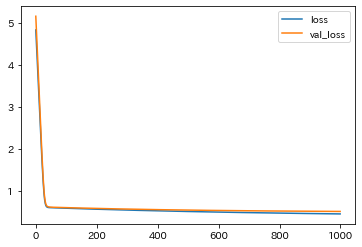

In [14]:
plt.plot(scr_lr.loss, label='loss')
plt.plot(scr_lr.val_loss, label='val_loss')
plt.legend()

# 【問題7】決定領域の可視化

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='sepal length (cm)', ylabel='petal length (cm)', 
                    target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

## 可視化するために特徴量を２つに絞る。

In [16]:
X_2_features = np.concatenate([X[:, 0].reshape(-1, 1), X[:, 2].reshape(-1, 1)], axis=1)

In [17]:
X_train_2_features, X_val_2_features, y_train, y_val = train_test_split(X_2_features, y, random_state=0)

In [18]:
scr_lr_2_features = ScratchLogisticRegression(1000, 0.01, True, False, 1)
lr_2_features = SGDClassifier(loss='log')

In [19]:
scr_lr_2_features.fit(X_train_2_features, y_train, X_val_2_features, y_val)
lr_2_features.fit(X_train_2_features, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
y_pred_scr_2_features = scr_lr_2_features.predict(X_val_2_features)
y_pred_2_features = lr_2_features.predict(X_val_2_features)

In [21]:
accuracy_score(y_val, y_pred_scr_2_features)

0.84

In [22]:
accuracy_score(y_val, y_pred_2_features)

0.88

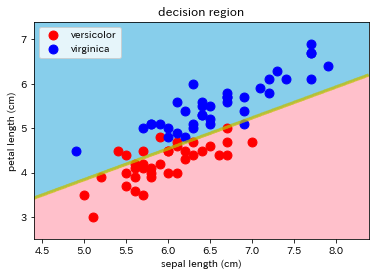

In [23]:
decision_region(X_train_2_features, y_train, scr_lr_2_features)

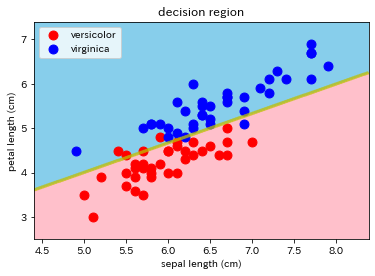

In [24]:
decision_region(X_train_2_features, y_train, lr_2_features)

# 【問題8】（アドバンス課題）重みの保存

In [25]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

In [26]:
theta = scr_lr_2_features.coef_
theta

array([[-0.37039629],
       [-0.67650326],
       [ 0.97501554]])

In [27]:
np.savez('theta.npz', theta)

In [28]:
npzfile = np.load('theta.npz')

In [29]:
npzfile.files

['arr_0']

In [30]:
npzfile['arr_0']

array([[-0.37039629],
       [-0.67650326],
       [ 0.97501554]])

## 今回の学習した重みをtheta.npzに保存することができた。